In [4]:
!pip install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 14.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827620 sha256=00f778a156162a9c4568dadb398771cd83f4f47fc489ab1e4f8b921ec6d2b6fb
  Stored in directory: /Users/reginachua/Library/Caches/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


In [1]:
# Necessary imports
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple

# For visualization
from IPython.display import HTML
from IPython import display 
import glob

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Function for normal distribution truncation:

from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#Function to get date sequence based on start_date and num_of_weeks:
# Works for Multi-Agent?

def get_date_seq(start_date_arr, num_of_weeks_arr): #start_date index 2, num_of_weeks index 3
    date_seq_arr = np.empty(shape=(len(start_date_arr),), dtype='object')
    for i in range(len(date_seq_arr)):
        date_seq_arr[i] = list(range(int(start_date_arr[i]), int(start_date_arr[i]) + int(num_of_weeks_arr[i])*7, 7))
    return date_seq_arr

#Function to get observation (still for single env, need to modify for multi-agent env):

def full_obs(_cap_dem_chosen_req, number_of_actions):
    _obs_min_arr = np.full((288+number_of_actions-1, ), 0)
    for i in range(len(_cap_dem_chosen_req)):
        _obs_min_arr[i+int((number_of_actions-1)/2)] = min(_cap_dem_chosen_req[i])
    return _obs_min_arr

#Function to get the one-hot-encoded vectors for departure and arrival airports:

def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

# Example usage
num_airports = 3
airport1 = 0
airport2 = 1
airport3 = 2

encoded_airport1 = one_hot_encode_airport(airport1, num_airports)
encoded_airport2 = one_hot_encode_airport(airport2, num_airports)
encoded_airport3 = one_hot_encode_airport(airport3, num_airports)

print(encoded_airport1)
print(encoded_airport2)
print(encoded_airport3)

#Generate full info for the arrival sides:

def generate_info_arv(requests):
    ts_arv = np.empty(shape=(len(requests),), dtype='object')
    start_date_arv = np.empty(shape=(len(requests),), dtype='object')
    #date_seq_arv = np.empty(shape=(len(requests),), dtype='object')
    for i in range(len(requests)):
        ts_arv[i] = requests[i][1] + requests[i][7]/5
        if ts_arv[i] > 287:
            ts_arv[i] = ts_arv[i] - 287
            start_date_arv[i] = requests[i][2] + 1
        else:
            start_date_arv[i] = requests[i][2]
    date_seq_arv = get_date_seq(start_date_arv, requests[:, 3])
    return ts_arv, start_date_arv, date_seq_arv

#Generate the multi-agent scenario:

#=======================================================

#Modify the distribution based on historical data later:
def generate_scenario(number_of_requests, num_airports, cap_dict):
    
    #number_of_requests = 15000
    ts_72 = get_truncated_normal(mean=72, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_72 = np.round(ts_72)

    ts_216 = get_truncated_normal(mean=216, sd=12, low=0, upp=287).rvs(int(round(number_of_requests/2)))
    ts_216 = np.round(ts_216)

    ts_dep = np.concatenate((ts_72, ts_216))
    ts_dep = ts_dep.astype(int)

    #Generate start date:

    start_date_dep = np.random.randint(low = 0, high=146, size=number_of_requests) #146 because period is 182 days and we consider series which span at least 5 weeks (+35 days)

    #Generate number of weeks:

    _max_day = np.full(number_of_requests, 182 - 1)

    _remaining_days = _max_day - start_date_dep

    _max_num_of_weeks = _remaining_days // 7

    num_of_weeks = np.random.randint(5, _max_num_of_weeks + 1)

    #Generate index for requests:

    index = np.array(list(range(number_of_requests)))

    #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):

    #num_airports = 3
    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    destination_airport = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range(number_of_requests):
        _org_airport = one_hot_encode_airport(random.randint(0,2), num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
        #Generate destination (the destination will be different with the origin):
        _dest_airport = _org_airport.copy()
        while np.array_equal(_dest_airport, _org_airport):
            np.random.shuffle(_dest_airport)
        _dest_airport_list = _dest_airport.tolist()
        destination_airport[i] = _dest_airport_list

    #Generate flying time (assume between airport 0 and 1 is 2 hour, 0 to 2 and 1 to 2 is arbitrary):

    fly_time = np.empty(shape=(number_of_requests,), dtype='object')
    for i in range (number_of_requests):
        if origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([1.0, 0.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = 120
        elif origin_airport[i] == list([0.0, 1.0, 0.0]) and destination_airport[i] == list([0.0, 0.0, 1.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([1.0, 0.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])
        elif origin_airport[i] == list([0.0, 0.0, 1.0]) and destination_airport[i] == list([0.0, 1.0, 0.0]):
            fly_time[i] = random.choice([60, 120, 180])

    #Get date sequence (date seq is actually a list):

    date_seq_dep = get_date_seq(start_date_dep, num_of_weeks)

    #Generate status cap:

    status_cap_dep = np.full((number_of_requests,), 0)
    status_cap_arv = np.full((number_of_requests,), 0)
    

    requests = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep), axis=1)

    #Generate full info for the arv side:

    ts_arv, start_date_arv, date_seq_arv = generate_info_arv(requests)

    #pseudo_belong_dep = np.full((number_of_requests,), 0)
    #pseudo_belong_arv = np.full((number_of_requests,), 0)
    
    # Define requests_full as dtype object
    # requests_full = np.stack((index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv), axis=1)
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 13), dtype=object)
    # Fill the array
    data = [index, ts_dep, start_date_dep, num_of_weeks, date_seq_dep, origin_airport, destination_airport, fly_time, status_cap_dep, ts_arv, start_date_arv, date_seq_arv, status_cap_arv]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    # airport_req_dict: A dictionary where each key corresponds to a specific airport's requirements. 
    # The key format is 'req_i', where i is the index of the airport. 
    # The value for each key is a numpy array, with each row representing a request and the columns containing different attributes of that request.
    airport_req_dict, _belong_airport_dict = get_airport_req_dict(requests_full, num_airports)

    pot_dem_dict = get_initial_pot_dem_per_airport(airport_req_dict, num_airports)

    cap_dem_dict = get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict)

    return requests_full, airport_req_dict, _belong_airport_dict, pot_dem_dict, cap_dem_dict

    #Generate capacity:

    #cap_arr = np.full((288, 182), 20)

    #Create final_sched:

    #final_sched_arr = req_arr.copy()

    #Get potential demand: #Check again the function here (turn to array)
    #pot_dem_arr = get_initial_pot_dem()

    #Get remaining cap:
    #cap_dem_arr = cap_arr - pot_dem_arr

    #  identify which requests from a set of airports violate a specific condition
# For each airport (from 0 to num_airports - 1), the function checks a condition based on the status_cap_dep and status_cap_arv 
# of the associated numpy array. If the sum of these two columns is greater than or equal to 1 (mask), it means that capacity is exceeded.
# For every airport that has violations, the function extracts the IDs of these violating requests.
# The function accumulates these IDs in the violate_set list.

def get_violate_id_set(airport_req_dict, num_airports):
    violate_set = [] #(1: id, 2: airport, 3: dep, 4: arv)
    for i in range(num_airports):
        mask = ((airport_req_dict['req_{}'.format(i)][:, 8] + airport_req_dict['req_{}'.format(i)][:, 12]) >= 1)
        _id_violate_per_airport = airport_req_dict['req_{}'.format(i)][mask, :][:,0]
        violate_set.append(_id_violate_per_airport)
    violate_set = np.concatenate(violate_set, axis=0)
    violate_set = np.unique(violate_set)
    return violate_set

def get_violate_id_set_req_full(requests_full):
    mask = ((requests_full[:, 8] + requests_full[:, 12]) >= 1)
    violate_set_req_full = requests_full[mask, :][:,0]
    return violate_set_req_full

def get_req(violate_set, requests_full):
    # if not violate_set:
    #     raise ValueError("The provided violate_set is empty!")
    _violate_index = random.choice(violate_set)
    chosen_req = requests_full[requests_full[:,0] == _violate_index]
    return chosen_req

def flatten_cap_dem_dict(cap_dem_dict, num_airports):
    cap_dem_dict_flat = {}
    for i in range(num_airports):
        cap_dem_dict_flat['req_{}'.format(i)] = cap_dem_dict['req_{}'.format(i)].flatten()
    return cap_dem_dict_flat

#Get separated req per airport and store in a dict:

def get_airport_req_dict(requests_full, num_airports):
    airport_req_dict = {}
    _belong_airport_dict = {}
    for i in range(num_airports):
        airport_req_dict['req_{}'.format(i)] = np.empty((0, 15)) #This one depends on the number of elements of a final request
        _belong_airport_dict['req_{}'.format(i)] = np.full(num_airports, 0.0, dtype=float)
        _belong_airport_dict['req_{}'.format(i)][i] = float(1.0)
        _belong_airport_dict['req_{}'.format(i)] = _belong_airport_dict['req_{}'.format(i)].tolist()
        
    for i in range(len(requests_full)):
        _found_dep = 0
        _found_arv = 0
        for k in range(num_airports):
            #_found_dep = 0
            #_found_arv = 0
            if requests_full[i][5] == _belong_airport_dict['req_{}'.format(k)]:
                _dep_req = np.append(requests_full[i], 1)
                _dep_req = np.append(_dep_req, 0)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _dep_req))
                _found_dep = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #break
            if requests_full[i][6] == _belong_airport_dict['req_{}'.format(k)]:
                _arv_req = np.append(requests_full[i], 0)
                _arv_req = np.append(_arv_req, 1)
                airport_req_dict['req_{}'.format(k)] = np.vstack((airport_req_dict['req_{}'.format(k)], _arv_req))
                _found_arv = 1
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 0)
                #airport_req_dict['req_{}'.format(k)] = np.append(airport_req_dict['req_{}'.format(k)], 1)
                #break
            if _found_dep + _found_arv == 2:
                break
        if _found_dep + _found_arv != 2:
            print("Cannot found both dep and arv at req {}".format(i))
            
    return airport_req_dict, _belong_airport_dict

def generate_deterministic_capacity_dict(num_airports, cap_per_airport_arr): #This function is for a period of 182 days and 288 slots/ day
    cap_dict = {}
    for i in range(num_airports):
        cap_dict['req_{}'.format(i)] = np.full((288, 182), cap_per_airport_arr[i])
    return cap_dict

def get_initial_pot_dem_per_airport(airport_req_dict, num_airports): #Replace req_df to req_df_update to update pot_dem_df #To be replaced with final_sched
    pot_dem_dict = {}
    #TODO: increase speed
    #13 dep 14 arv, 1 dep ts, 9 arv ts
    for i in range(num_airports):
        pot_dem_dict['req_{}'.format(i)] = np.full((288, 182), 0)
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            pot_dem_dict['req_{}'.format(i)][_time_slot, _date_seq] += 1
    return pot_dem_dict

def get_cap_dem_dict(num_airports, cap_dict, pot_dem_dict):
    cap_dem_dict = {}
    for i in range(num_airports):
        cap_dem_dict['req_{}'.format(i)] = cap_dict['req_{}'.format(i)] - pot_dem_dict['req_{}'.format(i)]
    return cap_dem_dict

def update_status_capacity(airport_req_dict, num_airports, cap_dem_dict, requests_full):
    #Them cot cap_status o init:
    for i in range(num_airports):
        for k in range(len(airport_req_dict['req_{}'.format(i)])):
            _time_slot = int(airport_req_dict['req_{}'.format(i)][k][1]) * int(airport_req_dict['req_{}'.format(i)][k][13]) + int(airport_req_dict['req_{}'.format(i)][k][9]) * int(airport_req_dict['req_{}'.format(i)][k][14])
            _date_seq = airport_req_dict['req_{}'.format(i)][k][4] * int(airport_req_dict['req_{}'.format(i)][k][13]) + airport_req_dict['req_{}'.format(i)][k][11] * int(airport_req_dict['req_{}'.format(i)][k][14])
            if all(x >= 0 for x in cap_dem_dict['req_{}'.format(i)][_time_slot, _date_seq]):
                #print(self.cap_dem_arr[_time_slot, _date_seq])
                airport_req_dict['req_{}'.format(i)][k][8] = 0
                airport_req_dict['req_{}'.format(i)][k][12] = 0
            else:
                if airport_req_dict['req_{}'.format(i)][k][13] == 1:
                    airport_req_dict['req_{}'.format(i)][k][8] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 8] = 1
                else:
                    airport_req_dict['req_{}'.format(i)][k][12] = 1
                    _indices = np.where(requests_full[:, 0] == airport_req_dict['req_{}'.format(i)][k][0])
                    requests_full[_indices, 12] = 1

In [ ]:
class TwoAirportSchedEnv(gym.Env):
    def __init__(self, number_of_actions, number_of_requests, num_airports, cap_per_airport_arr):
        #TODO: add agents to array - Roman
        self.agents=[]
        
        super(TwoAirportSchedEnv, self).__init__()
        self.number_of_actions = int(number_of_actions)
        self.number_of_requests = number_of_requests
        self.num_airports = num_airports
        #self.number_of_days = number_of_days
        self.cap_per_airport_arr = cap_per_airport_arr
        self.cap_dict = generate_deterministic_capacity_dict(self.num_airports, self.cap_per_airport_arr)
        #self.generate_scenario()
        #update the code to add generate scenario 
        self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests, num_airports, cap_dict = self.cap_dict)
        #to generate action:
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.observation_space = spaces.Box(low= -np.inf, high= np.inf, shape=(7,), dtype=float)

        #cap_dem_dict_flat = flatten_cap_dem_dict(cap_dem_dict, num_airports)
        #_generate = True
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        #for i in range(len(self.requests_full)):
        #  #print(self.requests_full[i][8], self.requests_full[i][12])
        
        _exceed_cap = 0         
        while _exceed_cap == 0:
            self.requests_full, self.airport_req_dict, self._belong_airport_dict, self.pot_dem_dict, self.cap_dem_dict = generate_scenario(number_of_requests = self.number_of_requests, num_airports = self.num_airports, cap_dict = self.cap_dict)
            self.cap_dem_dict_flat = flatten_cap_dem_dict(self.cap_dem_dict, self.num_airports)
            for i in range(num_airports):
                _exceed_cap = _exceed_cap + (min(self.cap_dem_dict_flat['req_{}'.format(i)]))
        

        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        self.num_step = 0
        
        #to choose the request that will be checked
        self.get_req()

        self.dep_time_slot = self.chosen_req[1]
        self.original_requests = self.requests_full
    
    def action_mapping(self, action, number_of_actions):
        mid_point = (number_of_actions - 1) // 2
        return action - mid_point
    
    #added get request to know which is the request we are going to move at this step",
    def get_req(self):
        violate_set=get_violate_id_set(self.airport_req_dict, num_airports)
        _violate_index = random.choice(violate_set)
        self.chosen_req = self.requests_full[self.requests_full[:,0] == _violate_index][0]
    
    #need to check arrival time or change the variable to check_outbound(arv) and chec_outbound(dep)
    def check_outbound(self, action):
        dep_time_slot = self.chosen_req[1]
        arv_time_slot = self.chosen_req[9]

        outbound = False

        new_dep_time_slot = dep_time_slot + action
        new_arv_time_slot = arv_time_slot + action

        if (new_dep_time_slot < 0) or (new_dep_time_slot > 287) or (new_arv_time_slot < 0) or (new_arv_time_slot > 287):
            outbound = True

        return outbound
    
    def dep_or_arv(self):
        pass

    def update_dem(self, dep_airport, arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, date_seq_dep, date_seq_arv):
        # Increment demand for the new time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][new_time_slot_dep, date_seq_dep] += 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][new_time_slot_arv, date_seq_arv] += 1

        # Decrease demand for the initial time slot for both departure and arrival airports
        self.pot_dem_dict['req_{}'.format(dep_airport)][time_slot_dep, date_seq_dep] -= 1
        self.pot_dem_dict['req_{}'.format(arv_airport)][time_slot_arv, date_seq_arv] -= 1

    def update_cap_dem(self):
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            if cap_key not in self.cap_dict:
                raise KeyError(f"'{cap_key}' not found in cap_dict. Available keys: {list(self.cap_dict.keys())}")
            self.cap_dem_dict[cap_key] = self.cap_dict[cap_key] - self.pot_dem_dict[dem_key]

    # Need to validate
    def update_violate_set(curr_violate, not_violate_update, violate_update):
        curr_violate = set(curr_violate)
        for req_index in not_violate_update:
            curr_violate.remove(req_index)
        for req_index in violate_update:
            curr_violate.add(req_index) 
        curr_violate = list(curr_violate)
        return curr_violate 
    
    # Based on agent's actions
    def take_action(self, action_dep, action_arv):
        #Check if actions match
        if action_dep != action_arv:
            return 0
        else:
            return action_dep
    
    def when_take_action(self, action):
        # num_actions = self.number_of_actions
        # # Convert the discrete action to your desired action value
        # real_action = self.action_mapping(action, num_actions)        

        _index = self.chosen_req[0]
        time_slot_dep = self.chosen_req[1]
        time_slot_arv = self.chosen_req[9]
        time_slot_arv = int(time_slot_arv)
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        _date_seq_dep = self.chosen_req[4]
        _date_seq_arv = self.chosen_req[11]
        _start_date_dep = self.chosen_req[2]
        _start_date_arv = self.chosen_req[10]
        _num_weeks = self.chosen_req[3]
        # new_time_slot_dep = time_slot_dep + real_action
        new_time_slot_dep = time_slot_dep + action
        # new_time_slot_arv = time_slot_arv + real_action
        new_time_slot_arv = time_slot_arv + action
        new_time_slot_arv = int(new_time_slot_arv)
        new_date_seq_dep = _date_seq_dep
        new_date_seq_arv = _date_seq_arv

        outbound = self.check_outbound(action)

        if not outbound:
            pass
            
        elif outbound:
            # Adjust the departure time slot as needed
            if new_time_slot_dep < 0:
                new_time_slot_dep = 287  # Move to the last time slot of the previous day
                new_start_date_dep = _start_date_dep - 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            elif new_time_slot_dep > 287:
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_start_date_dep = _start_date_dep + 1
                new_date_seq_dep = get_date_seq(new_start_date_dep, _num_weeks)
            # Adjust the departure time slot as needed
            if new_time_slot_arv < 0:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_arv = 287  # Move to the last time slot of the previous day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv - 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)
            elif new_time_slot_dep > 287:
                # Assume that we only move by max one slot for a timeslot change
                new_time_slot_dep = 0  # Move to the first time slot of the next day
                new_time_slot_arv = int(new_time_slot_arv)
                new_start_date_arv = _start_date_arv + 1
                new_date_seq_arv = get_date_seq(new_start_date_arv, _num_weeks)

        else:
            print('Problem with check outbound!')
            
        # Update the request for both departure and arrival time slots and dates
        self.requests_full[self.requests_full[:, 0] == _index][:, 1] = new_time_slot_dep
        self.requests_full[self.requests_full[:, 0] == _index][:, 9] = new_time_slot_arv
        # self.requests_full[self.requests_full[:, 0] == _index][:, 4] = new_date_seq_dep
        # self.requests_full[self.requests_full[:, 0] == _index][:, 11] = new_date_seq_arv
        _index_matching = np.where(self.requests_full[:, 0] == _index)[0][0]
        self.requests_full[_index_matching, 4] = new_date_seq_dep
        self.requests_full[_index_matching, 11] = new_date_seq_arv

        # Update the airport request dict
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_dep_airport)][self.airport_req_dict['req_{}'.format(_dep_airport)][:, 0] == _index][:, 9] = new_time_slot_arv
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 1] = new_time_slot_dep
        self.airport_req_dict['req_{}'.format(_arv_airport)][self.airport_req_dict['req_{}'.format(_arv_airport)][:, 0] == _index][:, 9] = new_time_slot_arv

        # Update demand for the new time slots
        self.update_dem(_dep_airport, _arv_airport, time_slot_dep, time_slot_arv, new_time_slot_dep, new_time_slot_arv, new_date_seq_dep, new_date_seq_arv)
        
        # Update cap_dem 
        self.update_cap_dem()

        # Update status capacity after the cap_dem table is updated
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)

    def step(self, action): 
        _num_weeks = self.chosen_req[3]
        self.when_take_action(action)
        outbound = self.check_outbound(action)

        # Reward part:
        if action != 0:
            
            local_reward = 0
            if outbound:
                # local_reward = -1
                local_reward = 0.1*(-abs(action)*0.5*_num_weeks)
            else:
                local_reward = 0.1*(-abs(action)*0.5*_num_weeks) #TODO change if increase number of actions
            
            self.num_step += 1
            done = False
            if self.chosen_req[8] == 0 and self.chosen_req[12] == 0:
                done = True
                obs = np.zeros((self.number_of_actions + 1,))
                global_reward = 10

            elif self.num_step == self.number_of_requests*5:
                done = True
                obs = np.zeros((self.number_of_actions + 1,))
                negative_sum = -10
                for value in self.cap_dem_dict.values():
                    # Assuming each value is a numeric value or a numpy array
                    # If it's a numpy array, you can sum all negative values directly using numpy
                    if isinstance(value, np.ndarray):
                        negative_sum -= np.sum(value[value < 0])
                    else:
                        # If it's a single numeric value, just check if it's negative
                        if value < 0:
                            negative_sum -= value
                global_reward = negative_sum

            else:
                global_reward = 0
                obs = self._next_observation()
                # obs = np.zeros((self.number_of_actions + 1,))

            reward_time_step = -0.5
        

        else:
            reward_time_step = -0.5
            local_reward = 0
            global_reward = 0

        total_reward = float(local_reward + global_reward + reward_time_step)
    
        return obs, total_reward, done, {}
    
    def _next_observation(self):
        self.get_req()
        _ts_dep = self.chosen_req[1]
        _ts_arv = self.chosen_req[9]
        _num_of_weeks = self.chosen_req[3]
        _date_seq_dep = self.chosen_req[4]
        _date_seq_arv = self.chosen_req[11]
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _cap_dem_dep = cap_dem_arr_dep[:, _date_seq_dep].copy()
        _cap_dem_arv = cap_dem_arr_arv[:, _date_seq_arv].copy()

        _obs_min_arr_dep = full_obs(_cap_dem_dep, self.number_of_actions)
        _obs_min_arr_arr = full_obs(_cap_dem_arv, self.number_of_actions)
        _obs_time_slot_related_dep = list(range(int(_ts_dep), int(_ts_dep + self.number_of_actions), 1))
        _obs_time_slot_related_arv = list(range(int(_ts_arv), int(_ts_arv + self.number_of_actions), 1))
        _cap_dem_obs_dep = _obs_min_arr_dep[_obs_time_slot_related_dep]
        _cap_dem_obs_arv = _obs_min_arr_arr[_obs_time_slot_related_arv]

        # Appending _cap_dem_obs_arv to _cap_dem_obs_dep
        self.obs = np.append(_cap_dem_obs_dep, _cap_dem_obs_arv)
        # append _num_of_weeks to the result of the above, do the following:
        self.obs = np.append(self.obs, _num_of_weeks)
        
        return self.obs

    def reset(self):                
        generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        
        _cap_dem_flat_dep = cap_dem_arr_dep.flatten()
        _cap_dem_flat_arv = cap_dem_arr_arv.flatten()

        while (min(_cap_dem_flat_dep) >= 0 or min(_cap_dem_flat_arv) >= 0):
            generate_scenario(self.number_of_requests, self.num_airports, cap_dict = self.cap_dict)
            _cap_dem_flat_dep = cap_dem_arr_dep.flatten()
            _cap_dem_flat_arv = cap_dem_arr_arv.flatten()
        
        update_status_capacity(self.airport_req_dict, self.num_airports, self.cap_dem_dict, self.requests_full)
        print('Number of violation for dep: ', len(_cap_dem_flat_dep[_cap_dem_flat_dep < 0]))
        print('Number of violation for arv: ', len(_cap_dem_flat_arv[_cap_dem_flat_arv < 0]))

        self.num_step = 0        
        return self._next_observation()
    
    # Need to validate
    def eval(self):
        _dep_airport = self.chosen_req[5].index(1.0)
        _arv_airport = self.chosen_req[6].index(1.0)
        _initial_cap_dem_dict = {}
        _initial_pot_dem_dict = get_initial_pot_dem_per_airport(self.airport_req_dict, self.num_airports)
        for airport in range(self.num_airports):
            cap_key = 'req_{}'.format(airport)
            dem_key = 'req_{}'.format(airport)
            _initial_cap_dem_dict[cap_key] = self.cap_dict[cap_key] - _initial_pot_dem_dict[dem_key]

        _initial_cap_dem_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        _initial_cap_dem_flat_dep = _initial_cap_dem_dep.flatten()
        _initial_violate_dep = len(_initial_cap_dem_flat_dep[_initial_cap_dem_flat_dep < 0])
        print('Initial violation of departure is: ', _initial_violate_dep)
        _initial_cap_dem_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _initial_cap_dem_flat_arv = _initial_cap_dem_arv.flatten()
        _initial_violate_arv = len(_initial_cap_dem_flat_arv[_initial_cap_dem_flat_arv < 0])
        print('Initial violation of arrival is: ', _initial_violate_arv)

        cap_dem_arr_dep = self.cap_dem_dict['req_{}'.format(_dep_airport)]
        cap_dem_arr_arv = self.cap_dem_dict['req_{}'.format(_arv_airport)]
        _final_cap_dem_flat_dep = cap_dem_arr_dep.flatten()
        _final_cap_dem_flat_arv = cap_dem_arr_arv.flatten()
        _final_violate_dep = len(_final_cap_dem_flat_dep[_final_cap_dem_flat_dep < 0])
        _final_violate_arv = len(_final_cap_dem_flat_arv[_final_cap_dem_flat_arv < 0])
        print('Final violation of departure is: ', _final_violate_dep)
        print('Final violation of arrival is: ', _final_violate_arv)

        _total_sched_delay_dep = sum(abs(self.original_requests[:,1] - self.requests_full[:,1])* self.original_requests[:,3])
        print('Total schedule delay of departure is: ', _total_sched_delay_dep)
        _total_sched_delay_arv = sum(abs(self.original_requests[:,9] - self.requests_full[:,9])* self.original_requests[:,3])
        print('Total schedule delay of arrival is: ', _total_sched_delay_arv)

        _max_shift_dep = max(abs(self.original_requests[:,1] - self.requests_full[:,1]))
        print('Max shift of departure: ', _max_shift_dep)
        _max_shift_arv = max(abs(self.original_requests[:,9] - self.requests_full[:,9]))
        print('Max shift of arrival: ', _max_shift_arv)

        _unaccom_req_dep = len(self.requests_full[self.requests_full[:,8] == 1])
        print('Number of unaccommodate departure requests: ', _unaccom_req_dep)
        _unaccom_req_arv = len(self.requests_full[self.requests_full[:,12] == 1])
        print('Number of unaccommodate arrival requests: ', _unaccom_req_arv)

        return _initial_violate_dep, _initial_violate_arv, _final_violate_dep, _final_violate_arv, _total_sched_delay_dep, _total_sched_delay_arv, _max_shift_dep, _max_shift_arv, _unaccom_req_dep, _unaccom_req_arv

In [9]:
# Initialize Two Airport Scheduler environment
env = TwoAirportSchedEnv(number_of_actions=3, number_of_requests=15000, num_airports=3, cap_per_airport_arr= [9,9,9])
# env.seed(0)

In [3]:
# Define Neural Network for Q Network
class QNetwork(nn.Module):
    # Initilize parameters to build model
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    # Build a network that maps state to action values
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [4]:
# Define the hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-2               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Define the agent
class Agent():
    # Initialize the Agent object
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    # Function to return actions for the given state based on the current policy
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # change this to just take random action and return the action after mapping
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    # Update the value parameters based on the given batch of experience tuples
    def learn(self, experiences, gamma):

        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        # Compute and minimize the loss
        # Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        # Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
# Define the Replay Buffer
class ReplayBuffer:
    # Initialize the Replay Buffer
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    # Add a new experience
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # Randomly sample a batch of experiences from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [20]:
import numpy
numpy.version.version

'1.24.3'

In [36]:
# Train the model
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            #env.combine_action
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent1 = Agent(state_size=8, action_size=4, seed=0)
agent2
agent3
scores = dqn()

(array([-0.00931454,  1.4230326 , -0.46551317,  0.25641942,  0.00889623,
        0.06900696,  0.        ,  0.        ], dtype=float32), 1.1759634873409948, False, False, {})


TypeError: expected np.ndarray (got numpy.float32)

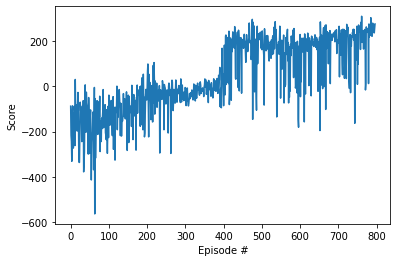

In [14]:
# Visualize the learning progress
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()